In [2]:
import pandas as pd
import numpy as np
import torch
from transformers import BertModel, BertTokenizer


/home/unknownsystem/Public/tt-pregrado/env_prueba/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Carga de modelo pre-entrenado BETO.

In [3]:
tokenizer_español = BertTokenizer.from_pretrained("../pytorch/", do_lower_case=False)
model = BertModel.from_pretrained("../pytorch")

Some weights of the model checkpoint at ../pytorch were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Ejemplo del uso de BERT

In [4]:
enunciado = "no se respeto las fechas de devolución.[PAD]"
print(f"Original: {enunciado}")
print(f"Tokenizado: {tokenizer_español.tokenize(enunciado)}")
print(f"IDs: {tokenizer_español.convert_tokens_to_ids(tokenizer_español.tokenize(enunciado))}")

Original: no se respeto las fechas de devolución.[PAD]
Tokenizado: ['no', 'se', 'respeto', 'las', 'fechas', 'de', 'devolución', '.', '[PAD]']
IDs: [1084, 1062, 5096, 1089, 10286, 1008, 17364, 1009, 1]


In [5]:
encoded = tokenizer_español("[CLS]hola como estan[SEP]¿Estan muy bien muchachos?[SEP]")
encoded

{'input_ids': [4, 4, 9050, 1184, 6974, 5, 1067, 20987, 1456, 1311, 7523, 1064, 5, 5], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

# Repesentación de texto formato BERT.

In [6]:
df = pd.read_csv("../data/raw/FalabellaAyuda_2022-11-18.csv")
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '../data/raw/FalabellaAyuda_2022-11-18.csv'

In [ ]:
texts = df["tweet_text"].head(15)
data = []
for text in texts:
    data.append(text)
data

['@FalabellaAyuda @Falabella_co @CMRayudaCL el servicio de Falabella banco es fatal. No puedo ver mis saldos de tarje… https://t.co/HbtRkI9eEo',
 '@FalabellaAyuda No lo hacen y te transfieren a otro teléfono',
 '@FalabellaAyuda Ya llamé, y he perdido horas tratando que resuelvan el problema y no pasa nada, solo se pasan la pe… https://t.co/IoW93Z61nx',
 '@FalabellaAyuda Para variar no hay respuesta! https://t.co/I2zgHiY8EB',
 '@FalabellaAyuda hola cuanto tarda una transferencia de fondos FPAY a mi cuenta banco falabella? la solicite hoy en… https://t.co/uVfGBv8HhA',
 '@FalabellaAyuda que pasa con mi compra Nº2034656615 sale entregada hace más de una semana y no me devuelven mi plat… https://t.co/VwszBlZSdP',
 '@FalabellaAyuda su aplicación fusionada con sodimac es verdaderamente un fiasco, cada vez que trato de comprar algo… https://t.co/qDzVlWjg0W',
 '@FalabellaAyuda @Banco_Falabella ayuda ya que desde una semana sea tratado de transferir y no ahy respuesta de llam… https://t.co/AaBWw

In [7]:
def bert_encoder(texts, tokenizer, max_length_text=140):
    """ Genera las entradas para el modelo BERT.
    Args:
        texts:
            List: lista de textos a tranformar.
        tokenizer:
            BertTokenizer.from_pretrained(): Bertokenizer cargado con BETO.
        max_lengh_text:
            Int: Cantidad maxima de tokens que se generaran,
            se truncara en 140 en caso que sobrepase.
    Returns:
        output:
            Dict: 
    Raises:
    """
    output = {}
    for text in texts:
        tokens = tokenizer.tokenize(text)
        tokens = ["[CLS]"] + tokens + ["[SEP]"]

        pads = max_length_text - len(tokens)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)
        input_ids += [1] * pads
        
        token_type_ids = [0] * max_length_text

        attention_mask = [1] * len(tokens) + [0] * pads

        if output:
            output["input_ids"] = torch.vstack((output["input_ids"], torch.tensor([input_ids])))
            output["token_type_ids"] = torch.vstack((output["token_type_ids"], torch.tensor([token_type_ids])))
            output["attention_mask"] = torch.vstack((output["attention_mask"], torch.tensor([attention_mask])))
        else:
            output["input_ids"] = torch.tensor([input_ids])
            output["token_type_ids"] = torch.tensor([token_type_ids])
            output["attention_mask"] = torch.tensor([attention_mask])
    return output

inputs = bert_encoder(enunciado, tokenizer_español)
inputs

{'input_ids': tensor([[   4, 1043,    5,  ...,    1,    1,    1],
         [   4, 1074,    5,  ...,    1,    1,    1],
         [   4,    5,    1,  ...,    1,    1,    1],
         ...,
         [   4, 1070,    5,  ...,    1,    1,    1],
         [   4, 1090,    5,  ...,    1,    1,    1],
         [   4,    3,    5,  ...,    1,    1,    1]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 0,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]])}

In [ ]:
outputs = model(**inputs)

last_hidden_states = outputs.last_hidden_state
last_hidden_states.shape

torch.Size([15, 140, 768])

# Extracción de características.

In [ ]:
def max_polling(tensor):
    output = []
    for vector in tensor:
        features_extracted=[]
        n = len(vector[:])
        for k in range(0, 768):
            max_element = float("-inf")
            for i in range(0, n):
                if (vector[i][k] > max_element):
                    max_element = float(vector[i][k])
            features_extracted.append(max_element)
        output.append(np.array(features_extracted))
    return output
max_polling(last_hidden_states)

[array([ 0.87277365,  1.01540768,  0.57219154,  1.97003841,  0.70999467,
         0.46061349,  1.12850857,  1.34987593,  0.95282745,  0.51418906,
         0.60078734,  1.18670678,  0.7682873 ,  1.13391745,  0.82038182,
         0.63518733,  1.49181902,  1.21387732,  0.48434845,  0.94280231,
         1.05297744,  1.44428432,  1.46179557,  1.29338706,  1.00760329,
         0.29663336,  0.9623239 ,  1.0039221 ,  1.45023119,  0.89823669,
         1.33613706,  0.85146648,  0.84866458,  0.31828317,  1.24424076,
         0.66313726,  0.78731298,  1.71906042,  0.87535924,  1.81728768,
         1.60241652,  1.438241  ,  0.97268105,  1.57014775,  0.68606269,
         1.66825223,  1.32015753,  0.7446785 ,  1.59841859,  1.37912035,
         1.06488979,  0.26180029,  1.15798581,  1.9162755 ,  0.54786086,
         0.92400682,  1.14855599,  0.92024577,  2.18728971,  1.64972436,
         0.63904542,  1.03700662,  0.98901391,  1.00124109,  1.36425996,
         0.594993  ,  1.66911757,  1.79582143,  0.9

In [ ]:
def mean_polling(tensor):
    output = []
    for vector in tensor:
        features_extracted=[]
        n=len(vector[:])
        for k in range(0, 768):
            sum_elements=0
            for i in range(0, n):
                sum_elements += float(vector[i][k])
            h=sum_elements/n
            features_extracted.append(h)
        output.append(np.array(features_extracted))
    return output
mean_polling(last_hidden_states)

[array([-2.94771721e-02, -6.03873498e-02, -3.82666741e-01,  1.20092605e-01,
         1.50213817e-01, -2.17391441e-01,  2.87109114e-01,  1.12678957e-01,
         9.71477909e-02, -3.53904859e-01, -1.74588780e-01, -1.73553641e-02,
        -1.09735192e-01, -4.40281782e-01, -1.84634329e-01, -7.82735877e-02,
         5.42468095e-01, -4.02630163e-01, -7.04731852e-01, -7.60556072e-02,
         2.33443503e-01,  4.65932395e-01, -1.02354154e-01,  1.70862071e-01,
        -9.42651263e-02, -3.47850330e-01, -8.29615004e-02, -1.17375545e-01,
        -3.11729488e-01,  4.12852571e-02,  3.41246707e-02, -1.36165853e-01,
        -3.28539179e-01, -4.23051529e-01,  1.00453950e-01, -6.28074705e-02,
        -1.76047590e-02,  2.96791782e-01, -1.69785165e-01,  8.09522757e-02,
         1.75697287e-01,  3.84808105e-01, -6.80929700e-02,  4.40521652e-02,
        -3.64189507e-01,  2.67122371e-01,  1.43365684e-01, -6.82348553e-02,
         1.12845914e-01,  3.66694998e-01,  1.99324352e-02, -3.29065231e-01,
        -3.0

# Normalización de caracteristicas.

In [ ]:
def std_normalization(list):
    output = []
    for vector in list:
        norm1_of_vector = vector.__abs__().sum()
        vector_normalized = vector / norm1_of_vector
        output.append(vector_normalized)
    return output
std_normalization(max_polling(last_hidden_states))

[array([ 0.00099301,  0.0011553 ,  0.00065102,  0.00224144,  0.00080781,
         0.00052407,  0.00128398,  0.00153584,  0.0010841 ,  0.00058503,
         0.00068356,  0.0013502 ,  0.00087413,  0.00129013,  0.0009334 ,
         0.00072269,  0.00169734,  0.00138111,  0.00055108,  0.00107269,
         0.00119804,  0.00164326,  0.00166318,  0.00147157,  0.00114642,
         0.0003375 ,  0.0010949 ,  0.00114223,  0.00165002,  0.00102198,
         0.00152021,  0.00096877,  0.00096558,  0.00036213,  0.00141566,
         0.0007545 ,  0.00089578,  0.00195589,  0.00099595,  0.00206765,
         0.00182318,  0.00163638,  0.00110668,  0.00178646,  0.00078058,
         0.00189808,  0.00150203,  0.00084727,  0.00181863,  0.00156912,
         0.0012116 ,  0.00029787,  0.00131752,  0.00218027,  0.00062334,
         0.0010513 ,  0.00130679,  0.00104702,  0.00248863,  0.001877  ,
         0.00072708,  0.00117987,  0.00112527,  0.00113918,  0.00155221,
         0.00067696,  0.00189907,  0.00204323,  0.0

In [ ]:
# tiene otro nombre z-score normalization (plis regularizar esto xd)
def z_score_normalization(list):
    output = []
    for vector in list:
        vector_normalized = (vector - vector.mean()) / vector.std()
        output.append(vector_normalized)
    return output
z_score_normalization(max_polling(last_hidden_states))

[array([-4.93545122e-01, -2.31147803e-01, -1.04651230e+00,  1.52504276e+00,
        -7.93002165e-01, -1.25177734e+00, -2.30812676e-02,  3.84158153e-01,
        -3.46273790e-01, -1.15321680e+00, -9.93905907e-01,  8.39833280e-02,
        -6.85763881e-01, -1.31307924e-02, -5.89927973e-01, -9.30621823e-01,
         6.45284387e-01,  1.33967728e-01, -1.20811322e+00, -3.64716589e-01,
        -1.62032429e-01,  5.57836962e-01,  5.90051606e-01,  2.80238156e-01,
        -2.45505190e-01, -1.55344409e+00, -3.28803604e-01, -2.52277294e-01,
         5.68777156e-01, -4.46701921e-01,  3.58883380e-01, -5.32742950e-01,
        -5.37897468e-01, -1.51361593e+00,  1.89825962e-01, -8.79203615e-01,
        -6.50763200e-01,  1.06333001e+00, -4.88788530e-01,  1.24403422e+00,
         8.48745540e-01,  5.46719352e-01, -3.09750044e-01,  7.89382171e-01,
        -8.37028736e-01,  9.69860497e-01,  3.29486572e-01, -7.29195919e-01,
         8.41390746e-01,  4.37957783e-01, -1.40117830e-01, -1.61752491e+00,
         3.1

In [ ]:
def max_min_normalization(list, new_min=0.0, new_max=1.0):
    output = []
    for vector in list:
        vector_normalized = (((vector - vector.min()) / (vector.max() - vector.min())) * (new_max - new_min)) + new_min
        output.append(vector_normalized)
    return output
max_min_normalization(max_polling(last_hidden_states))

[array([0.18683734, 0.20049754, 0.1580503 , 0.29192344, 0.17124784,
        0.14736436, 0.21132932, 0.23252988, 0.19450417, 0.15249535,
        0.16078895, 0.21690302, 0.17683058, 0.21184733, 0.18181972,
        0.16408347, 0.24612391, 0.21950517, 0.14963748, 0.19354405,
        0.20409563, 0.24157147, 0.24324854, 0.22711989, 0.1997501 ,
        0.13165983, 0.19541365, 0.19939755, 0.24214101, 0.18927596,
        0.2312141 , 0.18479673, 0.18452839, 0.13373325, 0.2224131 ,
        0.16676026, 0.17865269, 0.26788704, 0.18708496, 0.27729436,
        0.25671594, 0.24099269, 0.19640557, 0.25362553, 0.16895585,
        0.26302109, 0.22968372, 0.17456954, 0.25633306, 0.23533065,
        0.20523649, 0.12832383, 0.21415238, 0.28677452, 0.15572013,
        0.19174399, 0.21324928, 0.19138379, 0.31272981, 0.26124666,
        0.16445296, 0.20256609, 0.19796978, 0.19914079, 0.23390746,
        0.16023402, 0.26310396, 0.27523852, 0.19338167, 0.1909375 ,
        0.19561004, 0.32115771, 0.20805791, 0.29

In [ ]:
X = max_min_normalization(max_polling(last_hidden_states))

# Implementación de algoritmos de agrupamiento.

In [ ]:
from sklearn.cluster import KMeans
for seed in range(5):
    kmeans = KMeans(
        n_clusters=5,
        init="random",
        max_iter=100,
        n_init=1,
        random_state=seed,
    ).fit(X)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number of elements asigned to each cluster: {cluster_sizes}")
    print(f"labels:{kmeans.labels_}")

Number of elements asigned to each cluster: [1 2 7 2 3]
labels:[1 0 2 2 2 4 2 2 2 3 1 2 4 3 4]
Number of elements asigned to each cluster: [3 4 4 3 1]
labels:[4 3 2 2 1 0 2 1 2 3 1 1 0 3 0]
Number of elements asigned to each cluster: [6 2 3 1 3]
labels:[3 4 0 0 1 2 0 0 0 4 1 0 2 4 2]
Number of elements asigned to each cluster: [3 1 3 5 3]
labels:[1 2 4 4 3 0 3 3 4 2 3 3 0 2 0]
Number of elements asigned to each cluster: [3 1 6 3 2]
labels:[1 0 2 2 4 3 2 2 2 0 4 2 3 0 3]


In [ ]:
# K-means++
for seed in range(5):
    kmeans = KMeans(
        n_clusters=5,
        init="k-means++",
        max_iter=100,
        n_init=1,
        random_state=seed,
    ).fit(X)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number of elements asigned to each cluster: {cluster_sizes}")
    print(f"labels:{kmeans.labels_}")

Number of elements asigned to each cluster: [3 3 2 1 6]
labels:[3 1 4 4 2 0 4 4 4 1 2 4 0 1 0]
Number of elements asigned to each cluster: [4 2 1 7 1]
labels:[2 4 0 3 3 0 3 3 3 1 3 3 0 1 0]
Number of elements asigned to each cluster: [8 2 1 1 3]
labels:[2 3 0 0 0 4 0 0 0 1 0 0 4 1 4]
Number of elements asigned to each cluster: [2 3 3 1 6]
labels:[3 1 4 4 0 2 4 4 4 1 0 4 2 1 2]
Number of elements asigned to each cluster: [5 2 6 1 1]
labels:[3 4 2 2 0 2 0 0 2 1 0 0 2 1 2]


In [ ]:
# Fuzzy C-means
from fcmeans import FCM

X2 = np.array(X)
fcm = FCM(n_clusters=2)
fcm.fit(X2)
print(X2.shape)
fcm.centers

(15, 768)


array([[0.49248826, 0.5388205 , 0.48901149, ..., 0.49446072, 0.53101646,
        0.55163365],
       [0.30412895, 0.32091783, 0.25353617, ..., 0.2693507 , 0.30382632,
        0.33854357]])

In [ ]:
fcm.soft_predict(X2)

array([[0.89181013, 0.10818987],
       [0.05640273, 0.94359727],
       [0.98372616, 0.01627384],
       [0.98756173, 0.01243827],
       [0.98657929, 0.01342071],
       [0.92627694, 0.07372306],
       [0.99436648, 0.00563352],
       [0.99268918, 0.00731082],
       [0.99154062, 0.00845938],
       [0.00607342, 0.99392658],
       [0.9731905 , 0.0268095 ],
       [0.99151114, 0.00848886],
       [0.8945872 , 0.1054128 ],
       [0.0187755 , 0.9812245 ],
       [0.91119919, 0.08880081]])

In [ ]:
# eugenspace fuzzy c-means
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=3, n_iter=2)
X3 = svd.fit_transform(X2)
efcm = FCM(n_clusters=2)
efcm.fit(X3)
efcm.centers

array([[ 1.43980232e+01,  9.13611158e-01, -2.92503635e-02],
       [ 8.91161590e+00, -3.87988521e-01, -9.25260502e-03]])

In [ ]:
efcm.soft_predict(X3)

array([[1.06114729e-01, 8.93885271e-01],
       [9.47045338e-01, 5.29546619e-02],
       [9.64520809e-03, 9.90354792e-01],
       [7.44090961e-03, 9.92559090e-01],
       [8.75650317e-03, 9.91243497e-01],
       [6.60884295e-02, 9.33911571e-01],
       [1.02700510e-04, 9.99897299e-01],
       [2.04533883e-03, 9.97954661e-01],
       [1.72616442e-03, 9.98273836e-01],
       [9.96592825e-01, 3.40717479e-03],
       [2.20305519e-02, 9.77969448e-01],
       [1.42906939e-03, 9.98570931e-01],
       [9.58855088e-02, 9.04114491e-01],
       [9.83412579e-01, 1.65874207e-02],
       [8.40018039e-02, 9.15998196e-01]])

# extracción de enventos.

In [ ]:
import openai
import os
from config import OPENAI_API_KEY

openai.api_key = OPENAI_API_KEY
context = """
        Extrae eventos especificando el tipo de evento,
        tipos de evento:[Fecha, lugar, comparador, vendedor],
        el resultado retornalo como un diccionario de python, ejemplo:
        {
          "tipo_evento": "algo",
          "lugar": "algo",
          "fecha": "algo",
          "comprador": "algo",
          "vendedor": "algo",
        }
    """
text = """
        On January 2014, Google acquires artificial
        Event Type: Company Acquisition
        intelligence startup DeepMind with about 400M
        dollars. DeepMind is located in London and it 
        was founded by neuroscientist Demis Hassabis,
        a former child prodigy in chess, Shane Legg, 
        and Mustafa Suleyman. The acquisition was
        reportedly led by Google CEO Larry Page"
    """
response = openai.Completion.create(
    model="text-davinci-003",
    prompt=f"{context}:{text!r}",
    temperature=0.7,
    max_tokens=64,
    top_p=1.0,
    frequency_penalty=0.0,
    presence_penalty=0.0
)
print(response.choices[0]["text"])


    {
        "tipo_evento": "Company Acquisition",
        "lugar": "London",
        "fecha": "January 2014",
        "comprador": "Google",
        "vendedor": "DeepMind",
    }


In [ ]:
import ast
ast.literal_eval(response.choices[0]["text"].replace('Resultado:', ''))

{'Event Type': 'Company Acquisition',
 'Fecha': 'January 2014',
 'Lugar': 'London',
 'Comparador': 'Google',
 'Vendedor': 'DeepMind'}

For n_clusters = 2 The average silhouette_score is : 0.7049787496083262
For n_clusters = 3 The average silhouette_score is : 0.5882004012129721
For n_clusters = 4 The average silhouette_score is : 0.6505186632729437
For n_clusters = 5 The average silhouette_score is : 0.5662344175321901
For n_clusters = 6 The average silhouette_score is : 0.4358297989156284


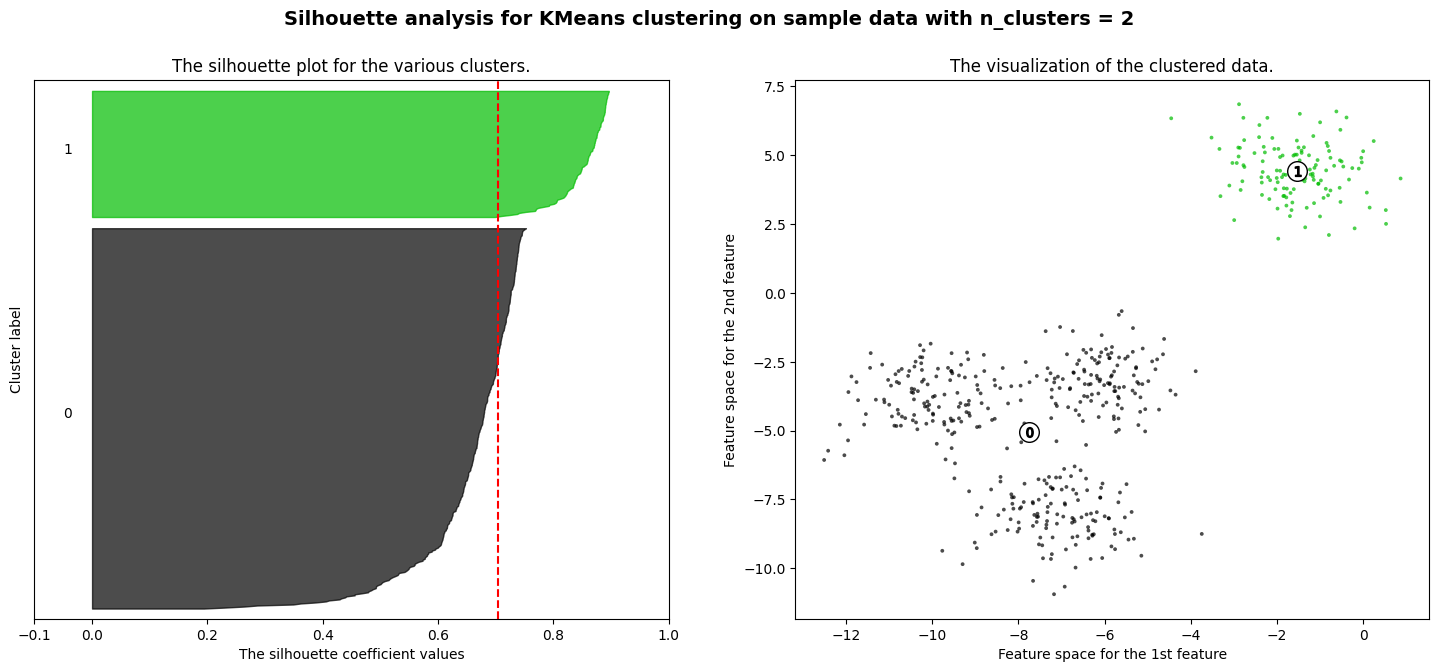

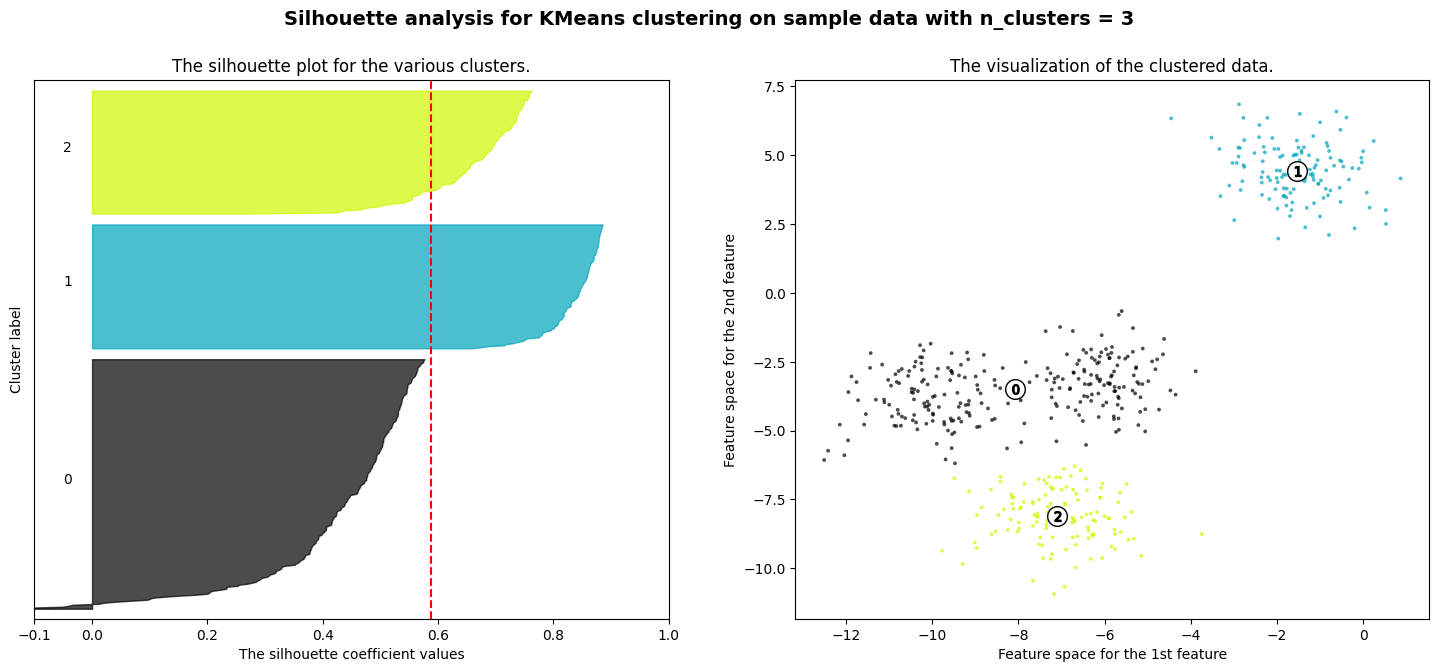

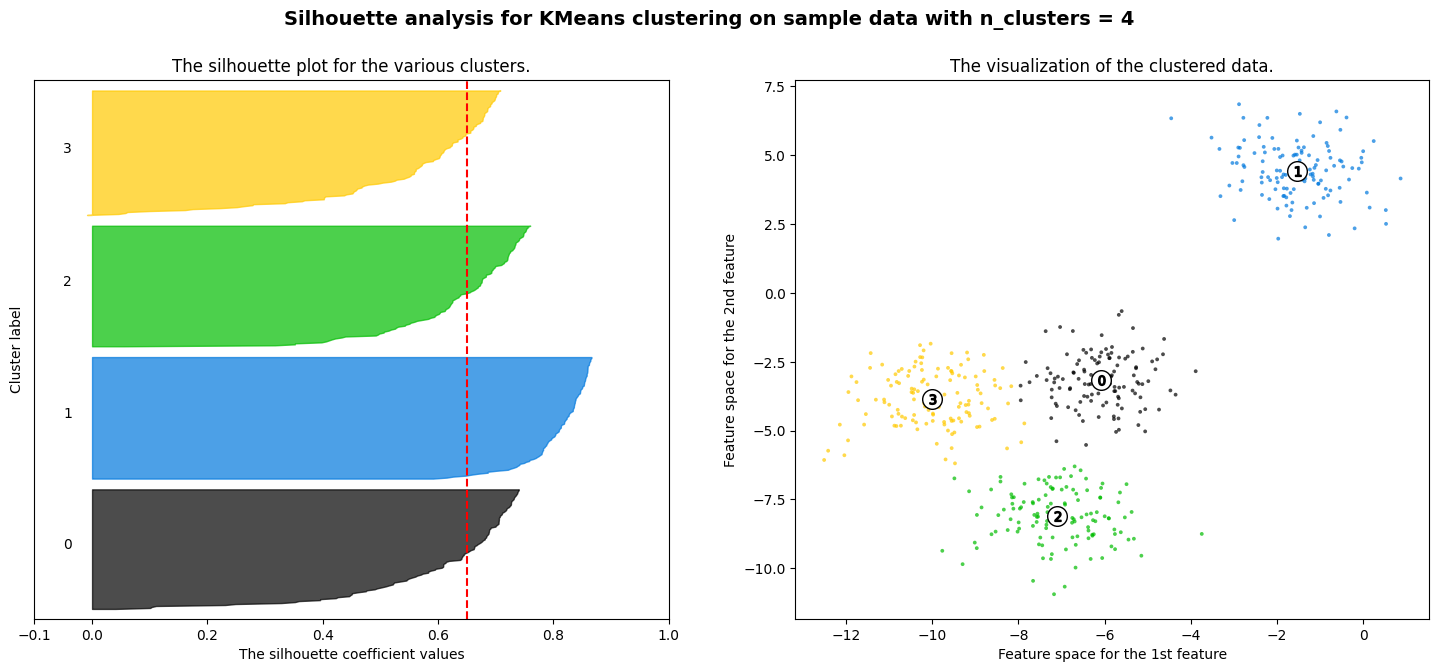

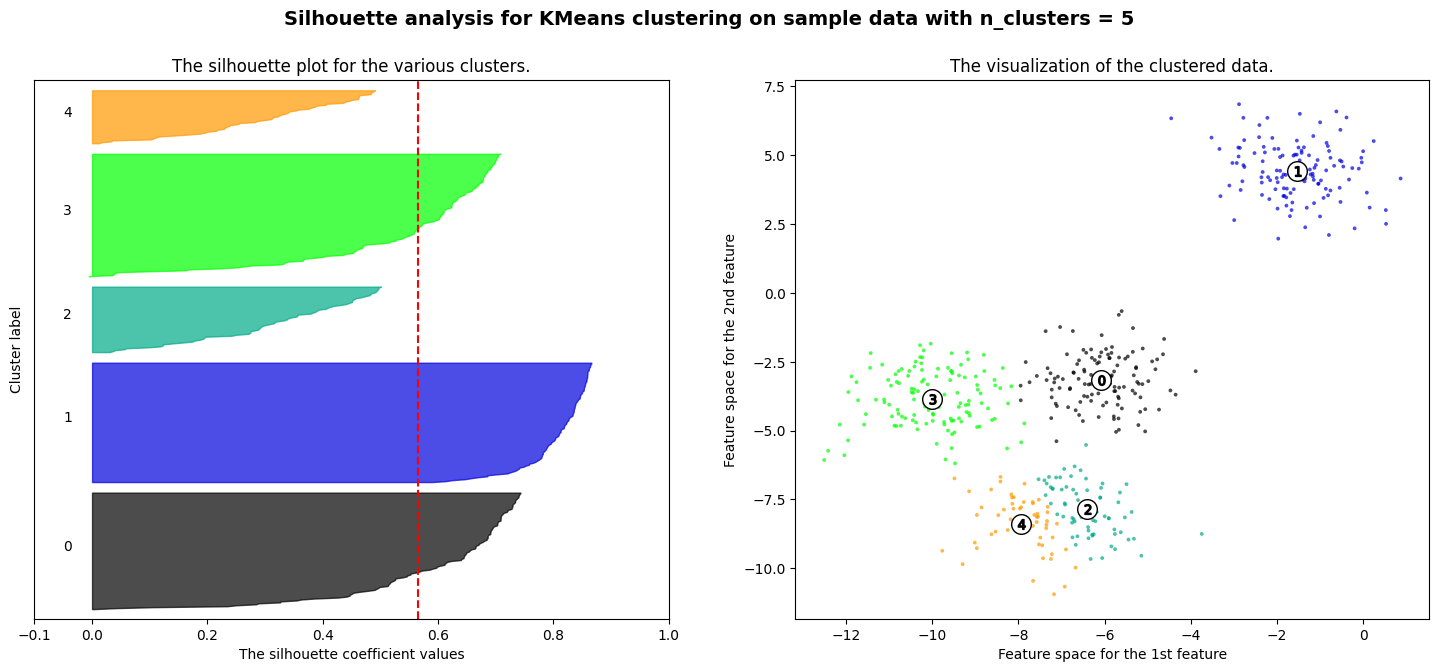

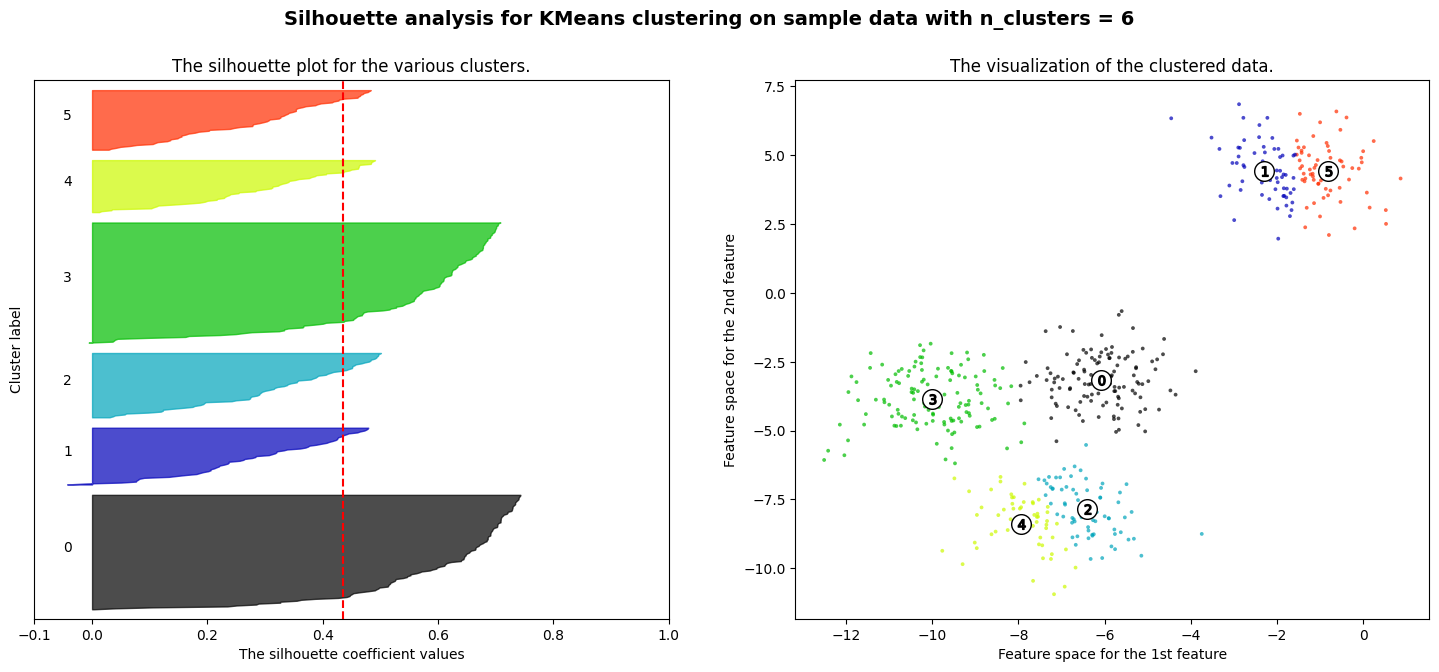

In [1]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=4,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=1,
)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

For n_clusters = 2 The average silhouette_score is : 0.3185897886956905
For n_clusters = 3 The average silhouette_score is : 0.2904326417014288
For n_clusters = 4 The average silhouette_score is : 0.2812650574446759
For n_clusters = 5 The average silhouette_score is : 0.281063950074744
For n_clusters = 6 The average silhouette_score is : 0.2741989302712257


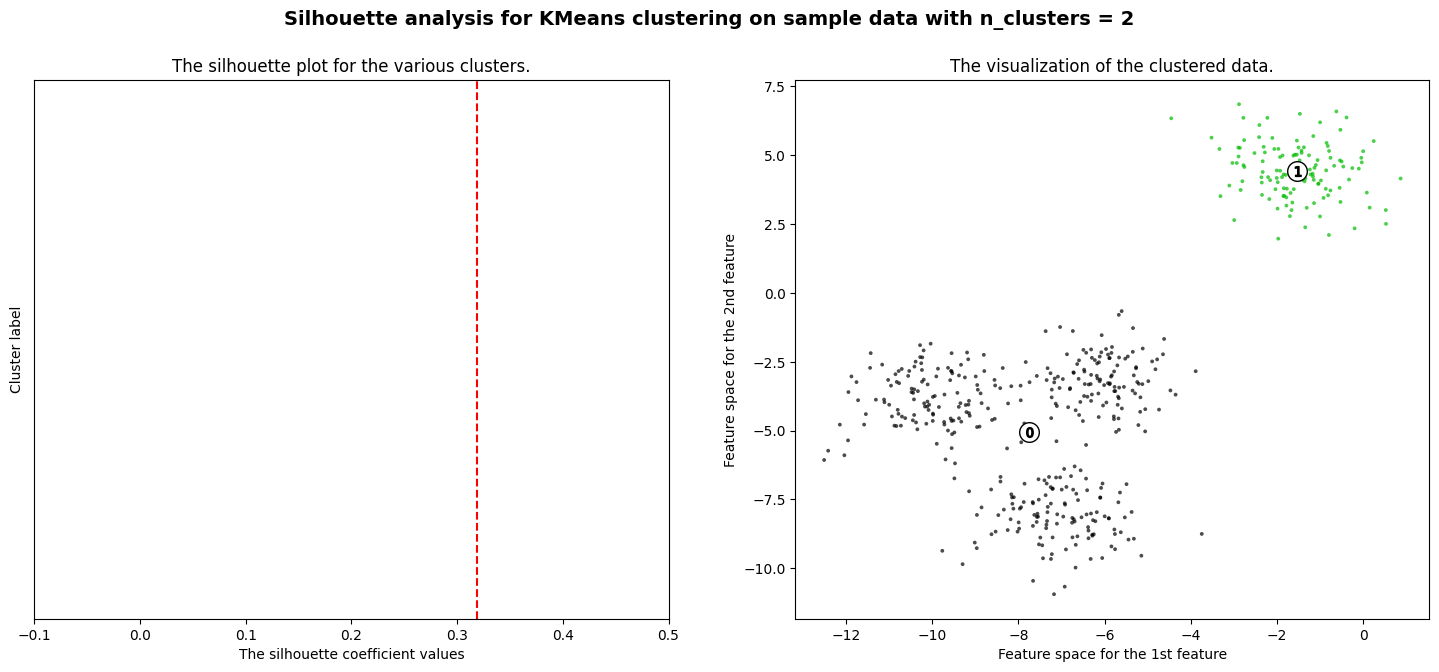

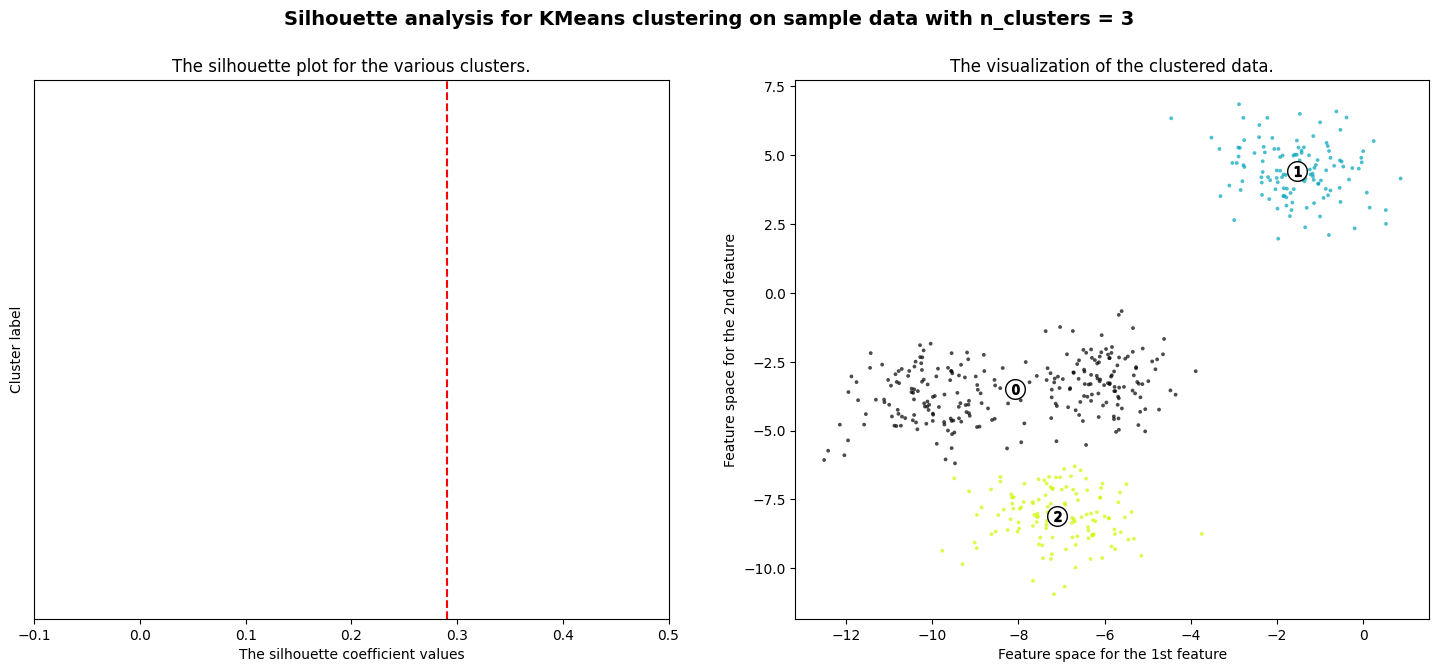

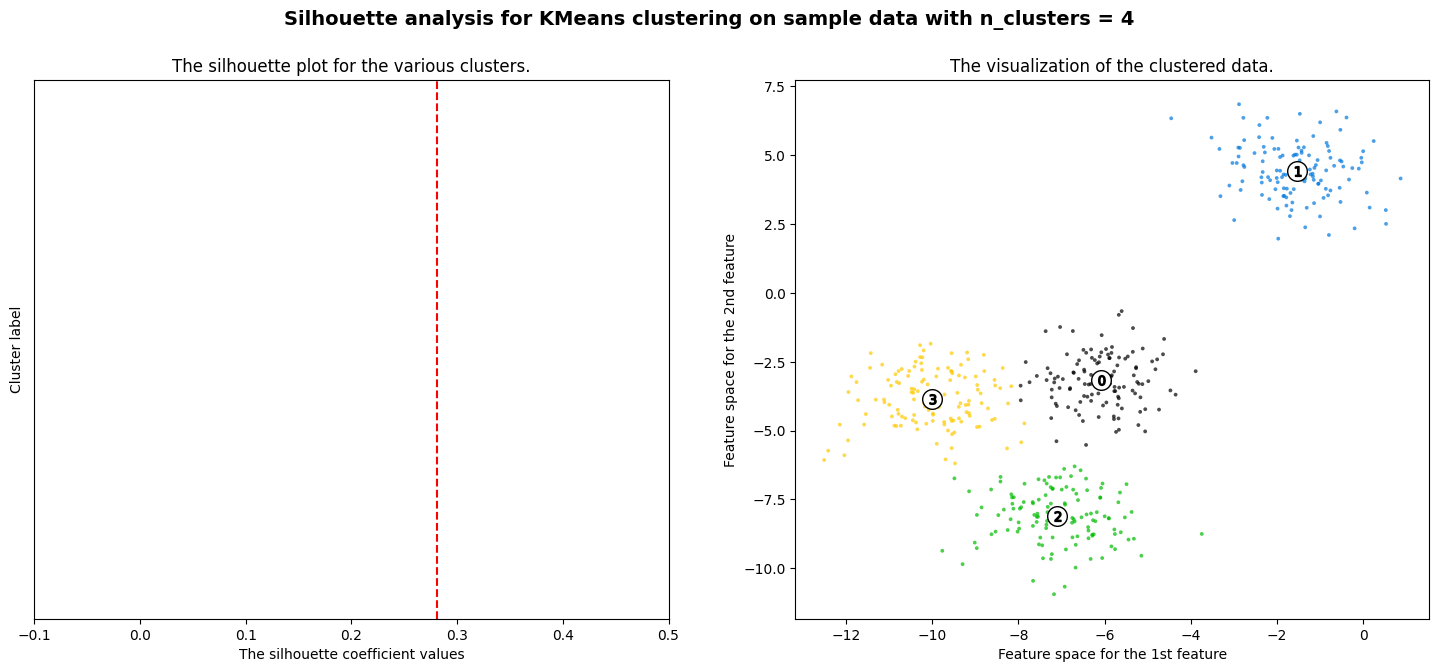

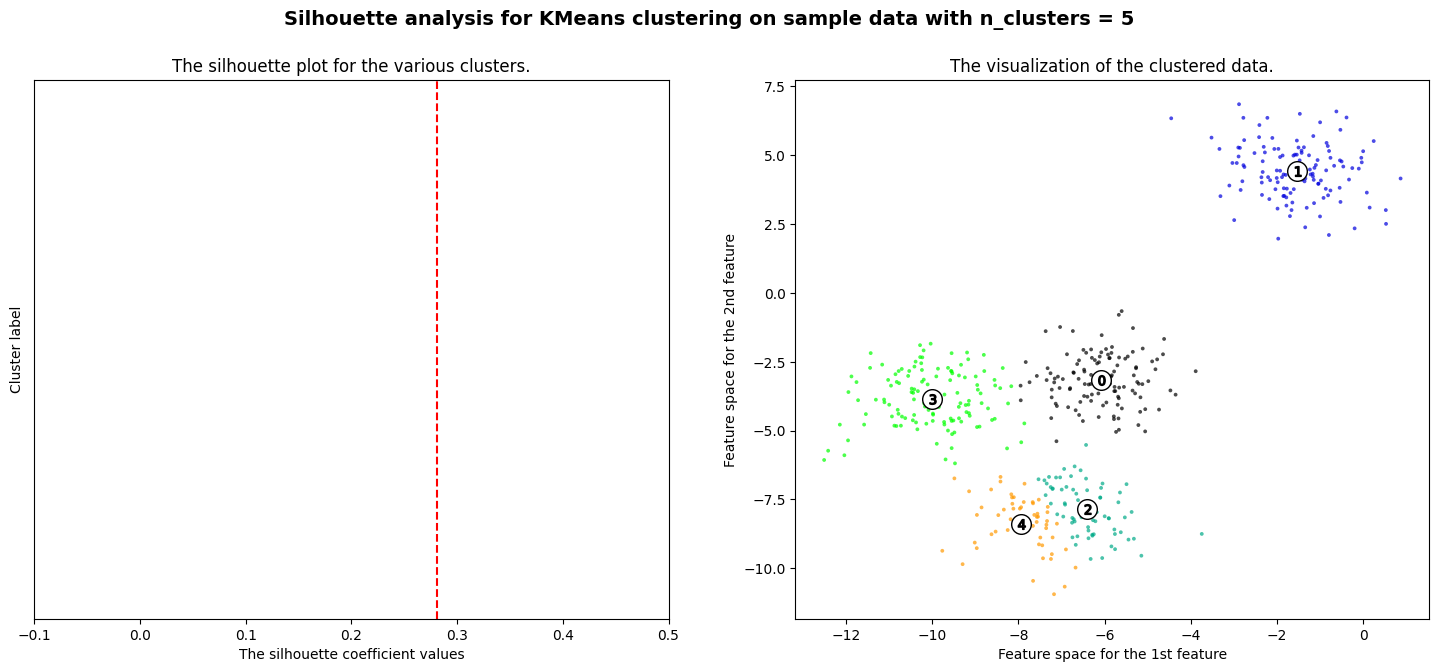

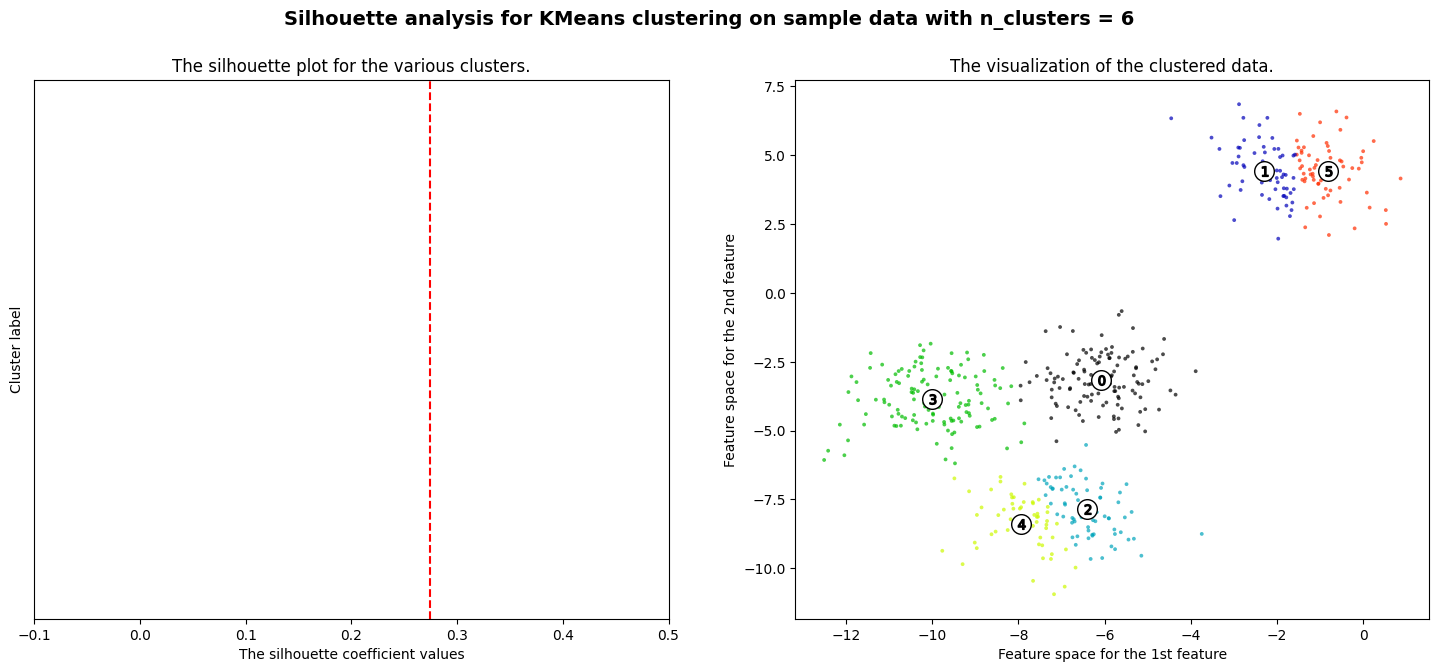

In [8]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from s_dbw import S_Dbw
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=4,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=1,
)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 0.5])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, n_init="auto", random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # Labeling the clusters
    centers = clusterer.cluster_centers_

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters

    silhouette_avg = score = S_Dbw(X, cluster_labels, centers_id=None, method='Tong', alg_noise='bind',
centr='mean', nearest_centr=True, metric='euclidean')
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )


    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()